In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.models as models
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from model import Backbone, Decoder
import yaml
from attrdict import AttrDict
from PIL import Image
import cv2
import os
from dataset import DIPLECSTrainDataset, DIPLECSTestDataset
import timm
from model import Model

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.onnx
import onnx
import math
torch.__version__

'1.8.1'

In [72]:
df = pd.read_csv('455_data/train_norm_denoised.csv')
df["bin"] = pd.cut(df.steer, bins=[-1.1, -0.75, -0.5, -0.25, -0.05, 0.05, 0.10, 0.15, 0.25, 0.5, 1.1], labels=False) + 1
df.

SyntaxError: invalid syntax (<ipython-input-72-c422c3dfe191>, line 3)

{5: 1135, 4: 474, 1: 400, 3: 361, 2: 359, 6: 27, 7: 25, 8: 23}


<AxesSubplot:>

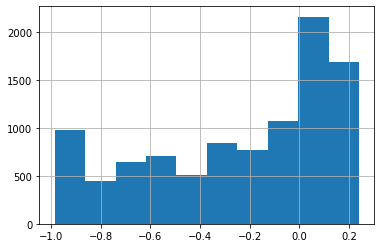

In [70]:
vc = dict(df.bin.value_counts())

os_df = df
n = 1000
for k, v in vc.items():
    
    if v < n:
        minority = df[df.bin == k].sample(n, replace=True)
        
        os_df = pd.concat([os_df, minority], axis=0)

        
print(vc)
os_df.steer.hist()

In [64]:
# os_df.to_csv('455_data/train_os.csv', index_label="index")

<AxesSubplot:>

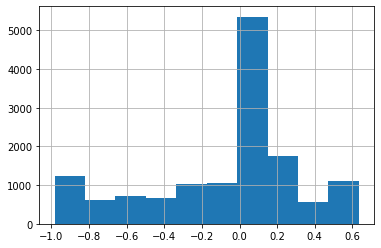

In [71]:
# pd.read_csv('data/train_os.csv').steer.hist()

In [73]:
# with open("./hparams.yaml") as f:
#     config = yaml.load(f, Loader=yaml.Loader)  # config is dict
#     cfg = AttrDict(config)
    
# model = Model.load_from_checkpoint(checkpoint_path="best_old_lightning_logs/version_1/checkpoints/epoch=15-val_loss=0.0563.ckpt")
model = Model.load_from_checkpoint(checkpoint_path="lightning_logs/version_0/checkpoints/epoch=11-val_loss=0.0794.ckpt")

decoder = model.decoder
decoder.eval()
# decoder_script = torch.jit.trace(decoder, torch.rand(1,3,120,320))
# decoder_script.save("decoder_script.pt")

backbone = model.backbone 
backbone.eval();
# backbode_script = torch.jit.trace(backbone, torch.rand(1,3,120,320))
# backbode_script.save("backbone_script.pt")

In [75]:
x = torch.rand(1,3,90,320)
out = backbone(x)
torch.onnx.export(backbone,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "onnx/455_backbone_os.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10, 
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'])# the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

In [76]:
x = torch.rand(1,8,512)
a = torch.rand(1,7).long()

torch.onnx.export(decoder,               # model being run
                  (x, a),                         # model input (or a tuple for multiple inputs)
                  "onnx/455_decoder_os.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output']) # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

In [5]:
import onnx

onnx_model = onnx.load("decoder.onnx")
onnx.checker.check_model(onnx_model)

In [120]:
train_df = pd.read_csv('data/train_norm_denoised.csv')

In [125]:
image_id = [str(i).zfill(4) + '.jpg' for i in range(len(train_df))]
train_df["image_id"] = image_id


In [130]:
trian_df = train_df.rename(columns={"data":"steer"})

,steer,image_id
0,0.0,0000.jpg
1,0.0,0001.jpg
2,0.0,0002.jpg
3,0.0,0003.jpg
4,0.0,0004.jpg
...,...,...
3506,-0.0,3506.jpg
3507,0.0,3507.jpg
3508,0.0,3508.jpg
3509,0.0,3509.jpg


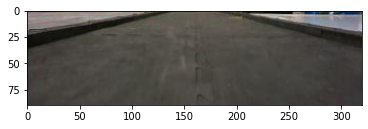

In [8]:
transform = A.Compose([
#     A.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, p=1.0),
#     A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0),
#     A.GaussNoise(var_limit=1, p=1.0),
#     A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.0, rotate_limit=0, p=.75)
#     A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
#     ToTensorV2()
])

img = cv2.imread("455_data/train/1624429046958567142.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (320, 240,))

img = transform(image=img)['image']
# plt.figure(figsize=(16,32))?
plt.imshow(img)

In [11]:
with open("./hparams.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)  # config is dict
    cfg = AttrDict(config)

cfg

AttrDict({'backbone': 'resnet18', 'd_model': 512, 'seq_l': 8, 'n_head': 4, 'lr': 0.0007, 'l2': 1e-08, 'bins': [-1.1, -0.5, 0.5, 1.1], 'div_factor': 25, 'final_div_factor': 100, 'pct_start': 0.2, 'warmup': 10000.0, 'anneal': 'cos', 'batch_size': 32, 'epochs': 20, 'p': 0.1})

In [8]:
decoder_script(torch.rand(16, 8, 512), torch.rand(16,7)).shape

torch.Size([16, 1, 1])

In [9]:
class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads
        
        self.register_buffer("in_proj_weight", None)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=self.in_proj_weight,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        print(x.shape)
        
        x = x[0]
        print(x.shape)
        return x

In [10]:
att_pool = AttentionPool2d(40, 512, 4, 128)

backbone = timm.create_model("resnet18", pretrained=True) 
backbone = nn.Sequential(*list(backbone.children())[:-2])


In [11]:
x = backbone(torch.rand(1,3,120,320))
print(x.shape)
x = att_pool(x)
x.shape

torch.Size([1, 512, 4, 10])
torch.Size([41, 1, 128])
torch.Size([1, 128])


torch.Size([1, 128])

In [11]:
stride = 0.1
bins = torch.Tensor([-1.1, -0.5, 0.5, 1.1])

steer_angles = torch.Tensor([-1.2, 0.4, 0, -0.4, 1.])
torch.bucketize(steer_angles, bins)

tensor([0, 2, 2, 2, 3])

In [58]:
data_id = "1315585148"
data_type = 'test'

df = pd.read_csv(f'PShape/control/{data_id}.dat', sep="\s+", names=['image_id', 'throttle', 'steer'])
df_mean = df.groupby('image_id').mean().reset_index()
df_mean = df_mean[:-3]
df_mean 

,image_id,throttle,steer
0,Image000002.jpg,33028.0,33028.0
1,Image000003.jpg,33028.0,33028.0
2,Image000004.jpg,33028.0,33028.0
3,Image000005.jpg,33028.0,33028.0
4,Image000006.jpg,33028.0,33028.0
...,...,...,...
1342,Image001344.jpg,46550.0,33028.0
1343,Image001345.jpg,46550.0,33028.0
1344,Image001346.jpg,46550.0,33028.0
1345,Image001347.jpg,46550.0,33028.0


<AxesSubplot:>

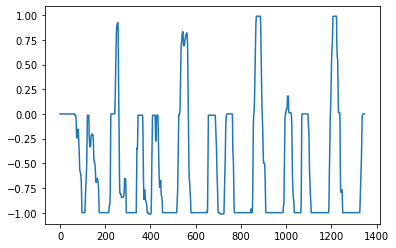

In [59]:
scale = (df_mean.steer.max() - df_mean.steer.min()) / 2
df_mean.steer = ((df_mean.steer - df_mean.steer[0]) / scale).round(4)
df_mean.steer.plot()

In [60]:
# norm_df.columns = ['index', 'data']
df_mean.to_csv(f'PShape/{data_type}_{data_id}/{data_id}.csv', index=False)
# plt.figure(figsize=(16,6))
# plt.plot(norm_df)

<AxesSubplot:>

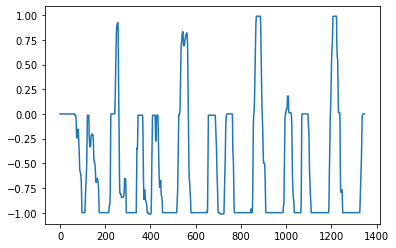

In [61]:
pd.read_csv(f'PShape/{data_type}_{data_id}/{data_id}.csv').steer.plot()

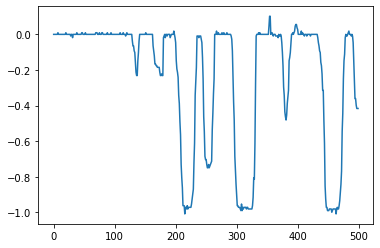

In [58]:
t = 'val'
data_dir = '455_data'

df = pd.read_csv(f'{data_dir}/{t}.csv')
# print(df.steer.min())
df.steer = (df.steer - 1508) / 432
df.steer[:500].plot()
# print(df.steer.min())

df.to_csv(f'{data_dir}/{t}_norm.csv', index=False)
# df.steer[:100].mode()

In [59]:
df = pd.read_csv(f'{data_dir}/{t}_norm.csv')
x = torch.from_numpy(df.steer.to_numpy())
data = x.flatten().float()

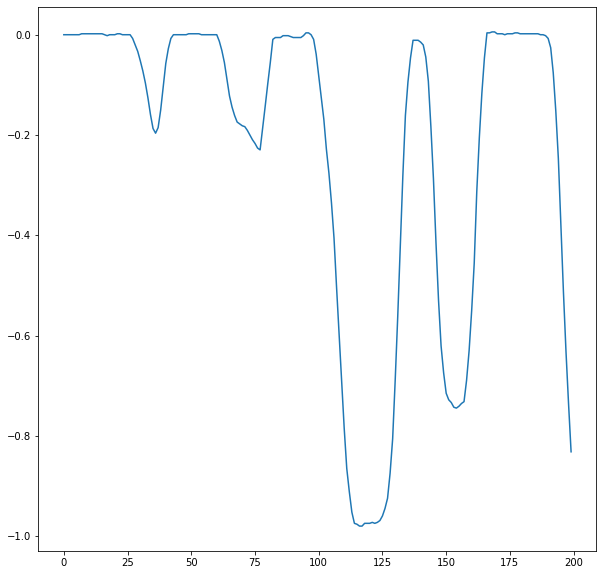

In [60]:
kernel = 5
padding = kernel // 2
conv = nn.Conv1d(1, 1, kernel_size=kernel, stride=1, padding=padding, bias=False)

conv.weight = torch.nn.Parameter(torch.ones(kernel)[None, None, :] / kernel)
conv.require_grad = False

x = conv(data.unsqueeze(0).unsqueeze(0))[0,0,:]
x = x.detach().numpy().round(4)

df.steer = x
df.to_csv(f'{data_dir}/{t}_norm_denoised.csv', index=False)
s = 100
e = 300
figure(figsize=(10,10))
plt.plot(x[s:e])#, plt.plot(data[s:e])
# denoised

<AxesSubplot:>

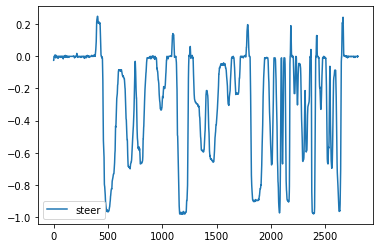

In [52]:
pd.read_csv('455_data/train_norm_denoised.csv').plot()

In [8]:
# !ffmpeg -r 10 -i 'comma/research/data/2016-01-30--13-46-00/images/%05d.jpg' -vcodec mpeg4 -y comma_2.mp4
!ffmpeg -r 10 -i 'udacity/udacity-driving-reader/output/center/%15d.jpg' -vcodec mpeg4 -y udacity.mp4

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/usrg/miniconda3/envs/robert3 --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
[image2 @ 0x55edb773abc0] Could find no file with path 'udacity/udacity-driving-reader/output/center/%15d.jpg' and index in the range 0-4
udacity/